<table width="100%">
    <td align="left">
        <a target="_blank", href="https://www.up.pt/fcup/en/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2023/03/FCUP_logo-print_blcktransp_600ppi.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td>
        <a target="_blank", href="https://www.iastro.pt/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2018/03/IA_logo_bitmap-rgbblack-1200px-388x259.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td align="center">
        <a target="_blank" href="https://colab.research.google.com/github/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-04-Density%20estimation.ipynb">
           <img src="https://tinyurl.com/3mm2cyk6"  width="90px" height="90px" style="padding-bottom:5px;"/>Run in Google Colab
        </a>
    </td>
<td align="center"><a target="_blank" href="https://github.com/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-04-Density%20estimation.ipynb">
<img src="https://tinyurl.com/25h5fw53"  width="90px" height="60px" style="padding-bottom:0px;"  />View Source on GitHub</a></td>
</table>

# Density estimation

Density estimation concerns trying to infer an underlying density/probability distribution from a set of observations. The methods used in standard machine learning typically do not account for uncertainties in the measurements which is sub-optimal for astronomy. 

Here we will explore a couple of different approaches and also see how to estimate the parameters of the different methods. 

In [214]:
# For Google Colab
# !wget --quiet -O catalog-of-pulsars.vot https://www.dropbox.com/scl/fi/dv2tnpo1lqoo20xzv1in8/catalog-of-pulsars.vot?rlkey=e9d6biwnr871xfrcl928pvmha&dl=0

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.table import Table
from astropy.visualization import hist

# Note that astropy also has a modification of hist that does the same as this one.
#from astroML.plotting import hist
%matplotlib inline

## A table of pulsars

This was downloaded from [Vizier](http://vizier.u-strasbg.fr/cgi-bin/VizieR) - table 1 from [Taylor et al (1995)'s Catalog of pulsars](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=VII/189). 

In [216]:
tPulsar = Table().read('../Datafiles/catalog-of-pulsars.vot')

## Finding the Galactic latitude distribution


Pulsars tend to be in the Galactic plane. To check whether this sample shows this we can create a histogram of the data. The following does this in the simplest possible way - using the default histogram function `hist`.

Text(0, 0.5, '# pulsars')

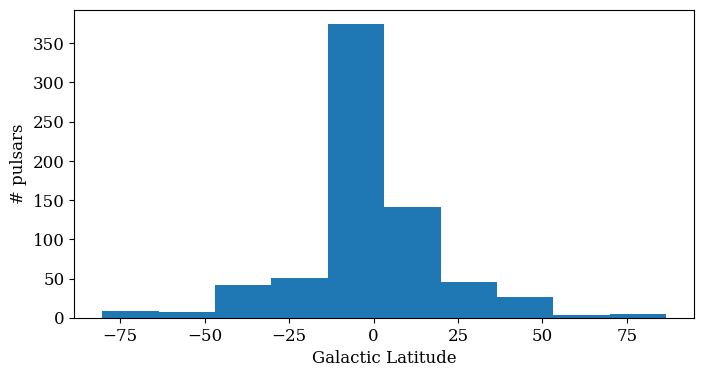

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
h = hist(tPulsar['GLAT'], ax=ax)
ax.set_xlabel('Galactic Latitude')
ax.set_ylabel('# pulsars')

That is not terribly nice - the bins are too big. If we want to stick with histograms, there are two main ways forwards: 

- using fixed size bins but using a more sophisticated method to estimate the bin width.
- using a flexible bin size that adapts to the data.

These have different advantages and disadvantages which we can discuss but to explore them it is useful to have a little convenience function to show one histogram.

In [218]:
def plot_histogram(data, binning_style, label, ax=None, xmin=-90, xmax=90, quiet=False):
    """
    Convenience routine for plotting a histogram.
    """

    if ax is not None:
        ax = plt.axes(ax)

    # Handle NaN's gracefully.
    keep = np.where(~np.isnan(data))
    
    counts, bins, patches = hist(data[keep], bins=binning_style, ax=ax,
                                 color='k', histtype='step', density=True)

    if not quiet:
        ax.text(0.95, 0.93, '{0:s}:\n{1:d} bins'.format(label, len(counts)),
                transform=ax.transAxes, ha='right', va='top')

    # Turn off y-axis labeling.
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(xmin, xmax)
    return ax

We can now use this function to show four different methods to estimate the density. The first three use fixed bin sizes but have different ways to estimate the bin size. The last, the Bayesian blocks method, has flexible bin sizes but unfortunately the implementation seems to show a bug. 

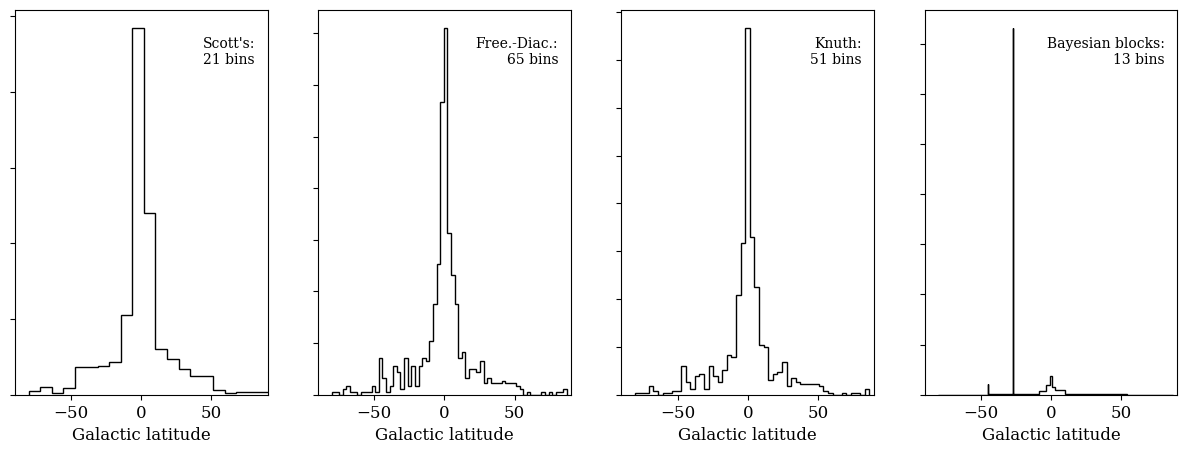

In [219]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
styles = ['scott', 'freedman', 'knuth', 'blocks']
titles = ["Scott's", 'Free.-Diac.', 'Knuth', 'Bayesian blocks']
for i in range(len(styles)):

    axis = plot_histogram(tPulsar['GLAT'], styles[i], titles[i], ax=ax[i])
    ax[i].set_xlabel('Galactic latitude')

It is possible to modify these histogramming routines, and for certain problem cases this is quite desirable - you can for instance ask for a minimum and maximum number of data points per bin, or create histograms with bins that are shifted and averaged to get a smoother histogram. See for instance [this Github project](https://github.com/ajdittmann/ash) for an implementation of these average smoothed histograms (ASH), or you can roll your own.

Another situation where you might want to have a modified histogram routine is if you want to take into account the uncertainties on your observations. One way to do this is to put the histogram call in a bootstrap and Monte Carlo loop and calculate a histogram with an uncertainty estimate on each bin.

But even the standard histogram can be very useful in certain situations. Say for instance that you want to calculate the average rotation measure in each bin in galactic latitude. You can do this by first calculating the histogram bins for the latitute and then use those bins to calculate the average [dispersion measure](https://astronomy.swin.edu.au/cosmos/*/Pulsar+Dispersion+Measure) (DM in the table) using code like the following:

In [220]:
# First calculate the bins for the latitude data.
data = tPulsar['GLAT']
keep = np.where((~np.isnan(data)) & (np.abs(data) < 100))
counts, bin_edges = np.histogram(data[keep], bins='doane')
bins = [[bin_edges[i], bin_edges[i+1]] for i in range(len(bin_edges)-1)]

#
# Then use np.digitize to calculate the bin each data point belongs to
# And then loop over the bins and calculate the average of all points
# that end up in that bin.
#
inds = np.digitize(data, bin_edges)
mean_DM = np.zeros(len(bins))
sd_DM = np.zeros(len(bins))
xDM = tPulsar['DM']
xdata = np.zeros(len(bins))
for i, b in enumerate(bins):
    in_this_bin, = np.where((inds == i) & (~np.isnan(xDM)) & (~np.isnan(data)))
 
    if (len(in_this_bin) > 1):
        mean_DM[i] = np.mean(xDM[in_this_bin])
        sd_DM[i] = np.std(xDM[in_this_bin])
        xdata[i] = np.mean(data[in_this_bin])
    else:
        mean_DM[i] = np.nan
        sd_DM[i] = np.nan
        xdata[i] = 0.5*(b[0]+b[1])

<ErrorbarContainer object of 3 artists>

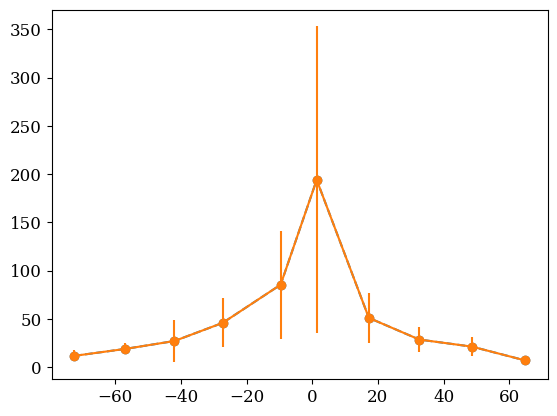

In [221]:
plt.plot(xdata, mean_DM, marker='o', ls='dashed')
plt.errorbar(xdata, mean_DM, sd_DM, marker='o')
#plt.ylim(-10, 50)

You might find it interesting(?) to figure out why the distribution and its scatter has the shape it has. For that you might find it interesting to look at the distance - `dist` in the table. 

# Kernel density estimates

With a kernel density estimate we can get a smoother estimate of the distribution and this is often useful, in particular if you need a derivative of the distribution! To do a kernel density estimate, we can use the `sklearn.neighbors` `KernelDensity` package. Before we do this, it might be useful to illustrate the different kernels available.

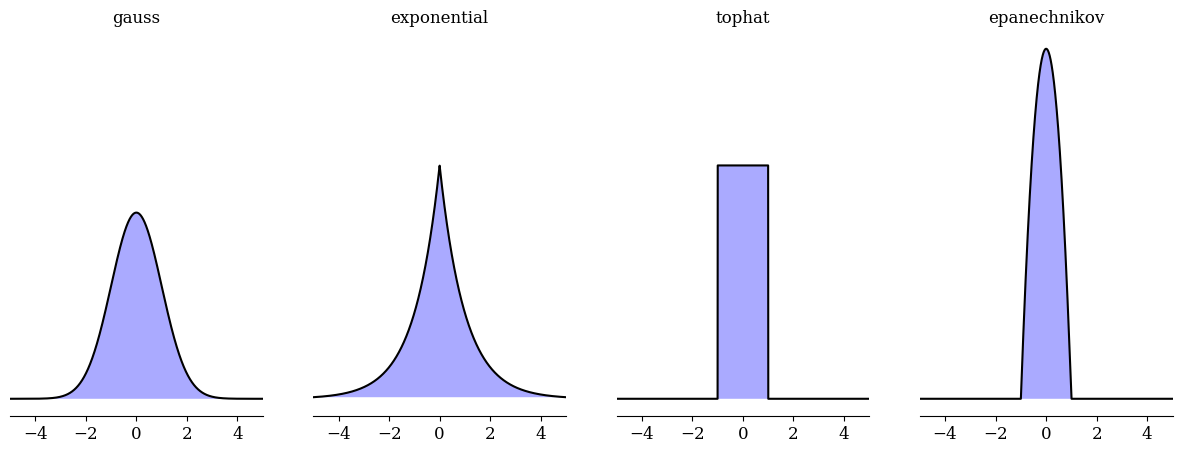

In [222]:
# Show the kernels over -5 to 5
from matplotlib.lines import Line2D
x = np.linspace(-5, 5, 5000)
dx = x[1] - x[0]

kernels = {'gauss': (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2),
           'exponential': 0.5 * np.exp(-abs(x)),
           'tophat': 0.5*np.ones_like(x)*(abs(x) < 1),
           'epanechnikov': 0.75*(1-x*x)*(abs(x) < 1)}
           

fig, axes = plt.subplots(1, 4, sharey=True, frameon=False)
fig.set_size_inches(15, 5)
fig.set_frameon(False)
# fig.figsize(5,15)
for (k, ax) in zip(kernels, axes):

    ax.plot(x, kernels[k], '-', c='black')
    ax.fill(x, kernels[k], '-k', fc='#AAAAFF')

    # This turns off the tick marks on the y-axis and removes the bars on the left, 
    # right and top. 
    ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()

    ax.set_xlim(-5, 5)    
    
    ax.set_title(k)


A key thing you can see in this figure is that the two kernels on the left both are limited to a finite range in x (they have finite support), while the exponential and Gaussian kernels extend to infinity (have infinite support). This can have implementation consequences - in some cases a kernel with finite support can be used to speed up calculations. The Epanechnikov kernel in addition has the nice theoretical property that it minimises variance (is least sensitive to a swap of data).

In [223]:
# I will use the KernelDensity class from Scikit-learn.
from sklearn.neighbors import KernelDensity

# from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm

The way the kernel density estimators in `scikit-learn` work is pretty much the same way as any machine learning method in `sklearn`, thus they can be coupled into a pipeline if that is convenient for your work.

First you fit the model to your observable (`.fit` below), then you evaluate the fitted model on new data. This is done with the `score_samples` routine below.

So let us try this out for the problem above to see how it works.

We first extract the data we want to fit (for convenience). Note that sklearn in general wants a 2D array as input - it will, for the moment, work for 1D arrays but complain. The `[:, None]` construction below adds a new final dimension to the otherwise 1D data.

In [224]:
X = tPulsar['GLAT'][:, None]

We then need to create the model we want to fit the data with. This is the `KernelDensity` model which requires two parameters: the bandwidth of the kernel - we will see below how to rigorously estimate this for now I use an eyeball value, and the type of kernel. I use the Gaussian kernel which in general works fine.

In [225]:
KDE_model = KernelDensity(bandwidth=5, kernel='gaussian')

And then we fit the data with this model:

In [226]:
kde_GLAT = KDE_model.fit(X)

The result of this call is an updated KernelDensity object that is now fit. Thus we can now input new values into the object and get predicted values out. To do this we use the `score_samples` function - this takes the x-values as input and gives out the log likelihood for that x value given the fitted KDE. 

In [227]:
# Create  the grid on which to evaluate the results
x_GLAT = np.linspace(-90, 90, 512)
x_GLAT = x_GLAT[:, None] # Oh yes, it needs to be 2D!

# Then evaluate the KDE solutions
log_dens_GLAT = kde_GLAT.score_samples(x_GLAT)

Text(0.5, 0, 'Galactic longitude')

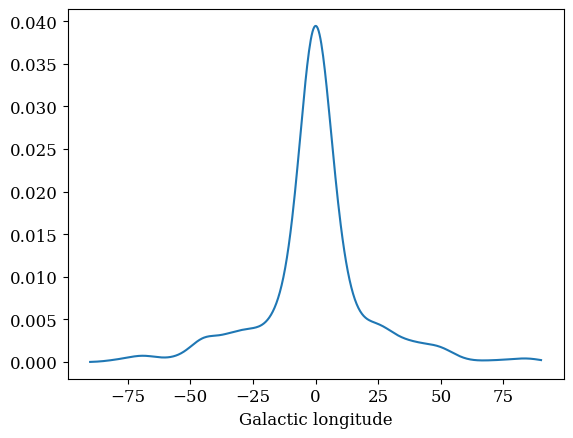

In [228]:
# Note that to have a plot that can be compared to the previous histograms we need to exponentiate!
plt.plot(x_GLAT, np.exp(log_dens_GLAT))
plt.xlabel('Galactic longitude')


## A KDE estimate for parallax

Here we will take the ideas above and apply them to the parallax of a subset of stars from Gaia. The column you need is `parallax`. 

What you need to do is:

1. Create a density estimate of the parallax using the three different kernels: `gaussian`, `tophat`, `exponential`, and `epanechnikov` and compare the result.
2. Determine the best bandwidth for one of these kernels and show how well constrained this bandwidth is.

In [229]:
# If you are on colab or haven't got the gaia stars file - uncomment the line below and download the file
# !wget --quiet -O gaia-stars.vot https://github.com/jbrinchmann/MLD2025/raw/refs/heads/main/Datafiles/gaia-stars.vot

In [230]:
t = Table().read("gaia-stars.vot", format='votable')

In [231]:
X = t['parallax'][:, None]

In [265]:
# Run the fit
kde = KernelDensity(bandwidth=0.1, kernel='gaussian').fit(X)
kde_th = KernelDensity(bandwidth=0.1, kernel='tophat').fit(X)
kde_exp = KernelDensity(bandwidth=0.1, kernel='exponential').fit(X)
kde_ep = KernelDensity(bandwidth=0.1, kernel='epanechnikov').fit(X)



In [233]:
# Create  the grid on which to evaluate the results
xout = np.linspace(0, 1.5, 512)
xout = xout[:, None]

# Then evaluate the KDE solutions
log_dens = kde.score_samples(xout)

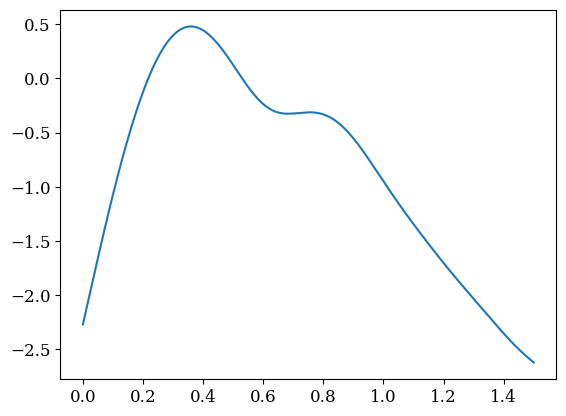

In [234]:
plt.plot(xout, log_dens)

To plot I will first plot the results using the Gaussian kernel and overplot a histogram.

Text(0.5, 0, 'Gaia parallax')

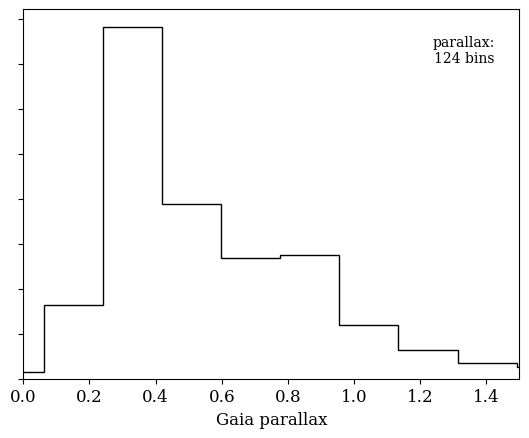

In [235]:
#plt.plot(xout, np.exp(log_dens))
fig, ax = plt.subplots()
y = t['parallax']
keep = np.where(~np.isnan(y))
ax = plot_histogram(y[keep], 'knuth', 'parallax', ax=plt.gca(), xmin=0, xmax=1.5)
ax.set_xlabel('Gaia parallax')


Let us now compare the different kernels.

Text(0, 0.5, 'p(x)')

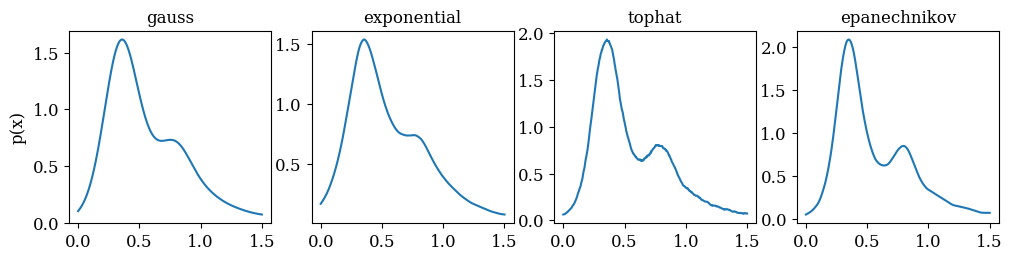

In [279]:
results = {'gauss': kde,
           'exponential': kde_exp,
           'tophat': kde_th,
           'epanechnikov': kde_ep}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2.5))
for i, key in enumerate(results.keys()):
    log_density = results[key].score_samples(xout)
    axes[i].plot(xout, np.exp(log_density))
    axes[i].set_title(key)
axes[0].set_ylabel('p(x)')

In [276]:
log_p_gauss = kde.score_samples(xout)

In [277]:
log_p_gauss.shape, xout.shape

((512,), (512, 1))

In [278]:
np.trapz(np.exp(log_p_gauss), xout[:,0])

0.9365285252077311

In [274]:
?np.trapz

Signature:       np.trapz(y, x=None, dx=1.0, axis=-1)
Call signature:  np.trapz(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function trapz at 0x10b78c720>
File:            ~/miniforge3/envs/mld2024/lib/python3.12/site-packages/numpy/lib/function_base.py
Docstring:      
Integrate along the given axis using the composite trapezoidal rule.

If `x` is provided, the integration happens in sequence along its
elements - they are not sorted.

Integrate `y` (`x`) along each 1d slice on the given axis, compute
:math:`\int y(x) dx`.
When `x` is specified, this integrates along the parametric curve,
computing :math:`\int_t y(t) dt =
\int_t y(t) \left.\frac{dx}{dt}\right|_{x=x(t)} dt`.

Parameters
----------
y : array_like
    Input array to integrate.
x : array_like, optional
    The sample points corresponding to the `y` values. If `x` is None,
    the sample points are assumed to be evenly spaced `dx` apart. The
    default is None.
dx : scalar, optional
    The

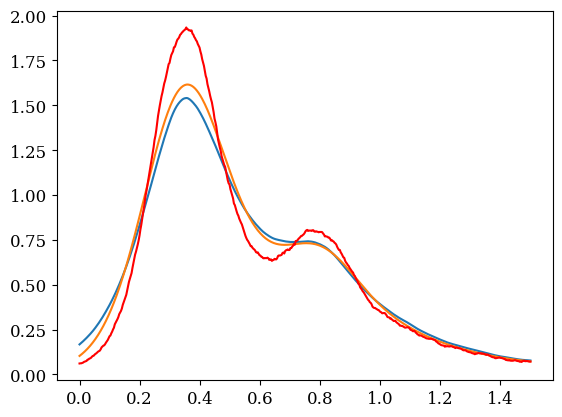

In [237]:
model_exponential = kde_exp # 
log_likelihood = model_exponential.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood))

model_gaussian = kde # 
log_likelihood = model_gaussian.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood))

model_tophat = kde_th # 
log_likelihood = model_tophat.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood), color='red')

The part below calculates the corss-validation score for a series of bandwidths. This is not the most elegant way to solve this - I'll show an alternative using `GridSearchCV` below, but this version is very explicit about what it is doing.

In [238]:
from sklearn.model_selection import KFold

def cv1(x, bws, model='gaussian', plot=False, n_splits=10):
    """
    Estimate bandwidth using leave-one-out cross-validation
    
    Input:
       x: data (assumed 1D)
       bws: Bandwidths to test (assumed 1D)
       
    Keywords:
       model: The kernel to use (default='gaussian')
       plot: Set this to true to show a big grid of the test and training
             samples with the KDE chosen at each step. This is not robust!
       n_splits: the number of folds to split the data into. Default=10.
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_splits), figsize=(15, 8))
        xplot = np.linspace(np.min(x), np.max(x), 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(n_splits=n_splits)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf.split(X):
            x_train = x[train, :]
            x_test = x[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=model, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Calculate the average likelihood          
        cv_1[i] = lnP/N
        
    return cv_1


Armed with this function, we can now get the cross-validation score.

In [239]:
X = t['parallax'][:, np.newaxis] # A different way to add a new axis = [:, None]
bws = np.linspace(0.05, 1, 50)
cv = cv1(X, bws)

Text(4, 0.001, 'Best BW=0.2439')

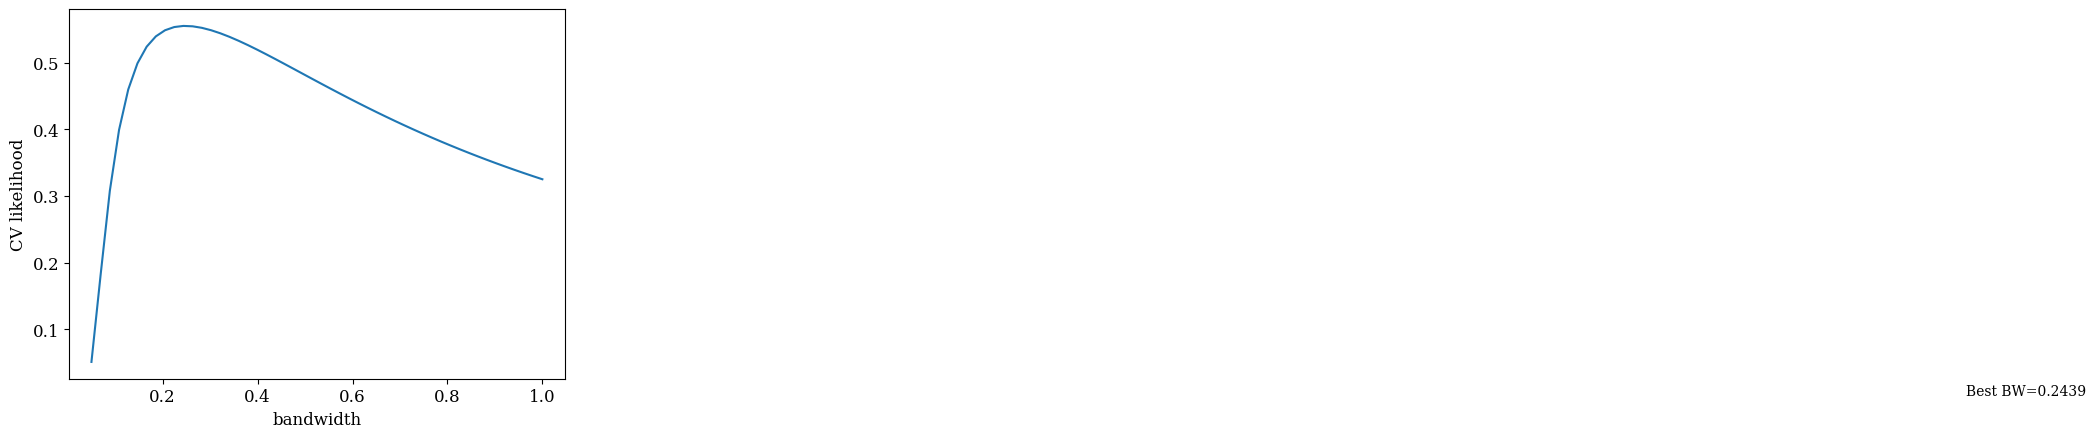

In [240]:
plt.plot(bws, np.exp(cv))
plt.xlabel('bandwidth')
plt.ylabel('CV likelihood')
plt.text(4, 0.001, 'Best BW={0:.4f}'.format(bws[np.argmax(cv)]))

You can improve (possibly) on this estimate by interpolation - this is more useful when you calculate the cross-validation score on a coarse grid.

In [241]:
bw_big = np.linspace(0.05, 1, 1000)
cv_big = np.interp(bw_big, bws, cv)
print("The linearly interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big)]))

The linearly interpolated maximum is=0.2440


In [242]:
from scipy import interpolate
f = interpolate.interp1d(bws, cv, kind=3)
cv_big2 = f(bw_big)
print("The quadratically interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big2)]))

The quadratically interpolated maximum is=0.2478


In [243]:
# U will use the quadratically interpolated maximum as the best
best_bw = bw_big[np.argmax(cv_big2)]

In practice the two are very close but the maximum is not terribly well constrained.

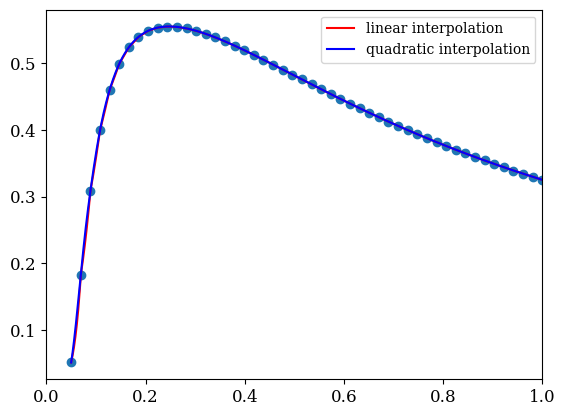

In [244]:
plt.plot(bws, np.exp(cv), 'o')
plt.plot(bw_big, np.exp(cv_big), 'r', label='linear interpolation')
plt.plot(bw_big, np.exp(cv_big2), 'b', label='quadratic interpolation')
plt.xlim(0, 1)
#plt.ylim(0.011, 0.0132)
plt.legend()

So let us see the result

In [245]:
kde = KernelDensity(bandwidth=best_bw, kernel='gaussian').fit(X)

Text(0.5, 1.0, 'Best bandwidth from CV')

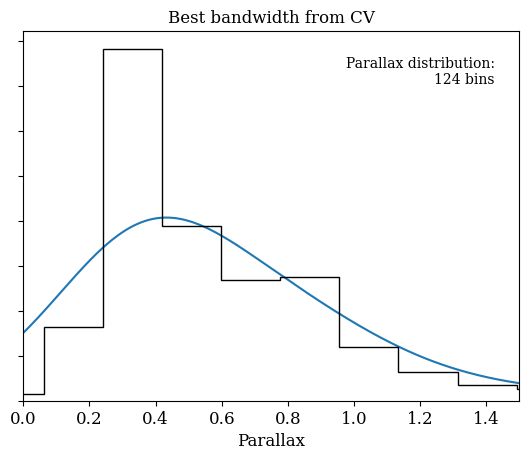

In [246]:
# We use the output grid defined above.

# Then evaluate the KDE solutions
log_dens = kde.score_samples(xout)

plt.plot(xout, np.exp(log_dens))
ax = plot_histogram(t['parallax'], 'knuth', 'Parallax distribution', ax=plt.gca(), xmin=0, xmax=1.5)
ax.set_xlabel('Parallax')
ax.set_title('Best bandwidth from CV')

## A version using GridSearchCV 

The code above is quite verbose, and if we wanted to also optimise over the kernel type we would need to extend it a bit. An alternative that takes less lines is to use GridSearchCV - this is shown below. To have a reasonable execution time, I would recommend using a k-fold of 5 rather than 10

In [247]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bandwidth': bws, 'kernel': ['gaussian']}
cv = KFold(5)
search = GridSearchCV(estimator=KernelDensity(),
                      param_grid=param_grid, cv=cv)                           
search.fit(X, y)
print("The best order = {0}".format(search.best_params_))

The best order = {'bandwidth': 0.24387755102040815, 'kernel': 'gaussian'}


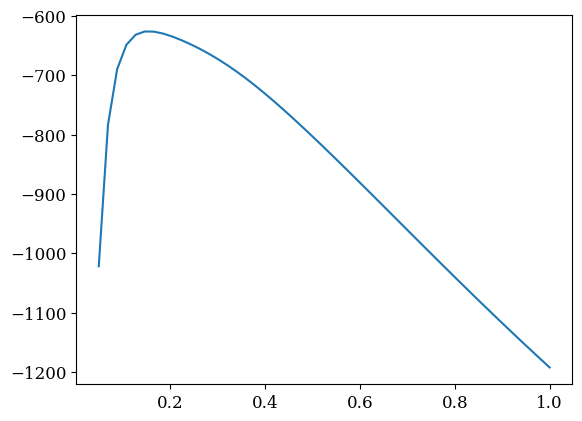

In [248]:
plt.plot(bws, search.cv_results_['split0_test_score'])

# Gaussian mixture models

Another way to fit a distribution is to use Gaussian mixture models. These are basically combinations of Gaussians where we write that the distribution is defined as 
$$p(x_i|\theta) = \sum_{j=1}^M \alpha_j N(x_i; \mu_j, \sigma_j^2)$$
with $M$ being the number of Gaussians (a hyper-parameter) and where I have specialised to 1D so that the covariance matrix reduces to a single variance, $\sigma_j^2$. We can use this both to infer the properties of an unknown (or known) set of Gaussians or just as a convenient way to describe a density distibution. 

In `sklearn` we do this as follows (for two Gaussians):

In [249]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(2)

In [250]:
res = model.fit(X)

We can get the means of the two Gaussians and their widths using:

In [251]:
print("The means of the Gaussian components = ", res.means_)

The means of the Gaussian components =  [[0.53210407]
 [1.62947579]]


In [252]:
print("The covariances (here sigmas) = ", res.covariances_)

The covariances (here sigmas) =  [[[0.07935465]]

 [[2.89110159]]]


If we now look at this as the combination of two likelihoods, we can classify each data point as belonging to one Gaussian or the other using the `predict` function: 

In [253]:
labels = res.predict(X)

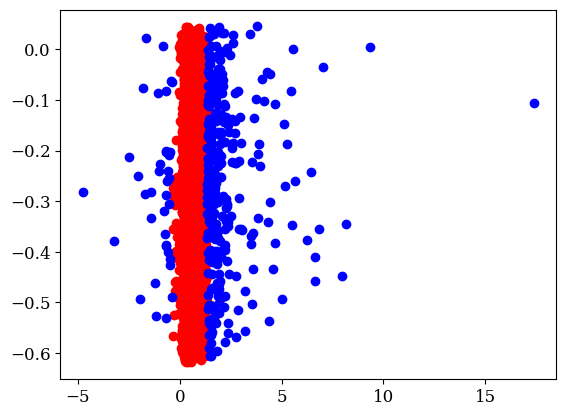

In [254]:
plt.scatter(t['parallax'][labels==0], t['b'][labels==0], color='red')
plt.scatter(t['parallax'][labels==1], t['b'][labels==1], color='blue')

This illustrates a common issue with Gaussian expansions - the component with largest $\sigma$ tends to dominate at large radii - whether this is physically meaningful or not is up to you to understand.

In order to visualise the results, we use the `score_sample` function on data along the axis we want to sample. This is a 1D example - in the (maybe more common?) 2D case you would create a 2D `xout` array

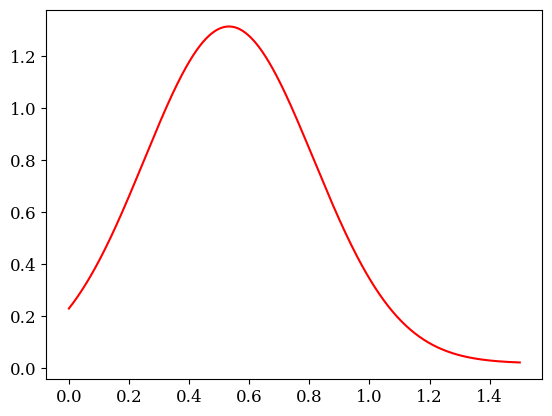

In [255]:
log_likelihood = model.score_samples(xout)
plt.plot(xout, np.exp(log_likelihood), color='red')

But we need to be rigorous and estimate the optimal number of Gaussian components as well. 

In [256]:
param_grid = {'n_components': np.arange(1, 20)}
cv = KFold(10)
search = GridSearchCV(estimator=GaussianMixture(),
                      param_grid=param_grid, cv=cv)                           
search.fit(X, y)
print("The best number of components = {0}".format(search.best_params_))

The best number of components = {'n_components': 11}


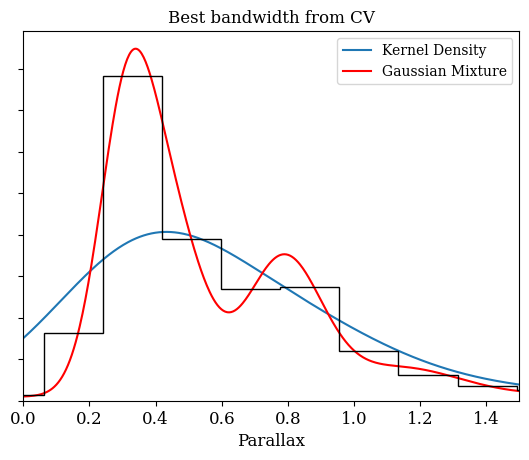

In [257]:
model = GaussianMixture(n_components=search.best_params_['n_components'])
res = model.fit(X)
log_likelihood = model.score_samples(xout)

plt.plot(xout, np.exp(log_dens), label='Kernel Density')
plt.plot(xout, np.exp(log_likelihood), color='red', label='Gaussian Mixture')
ax = plot_histogram(t['parallax'], 'knuth', 'Parallax distribution', ax=plt.gca(), xmin=0, xmax=1.5, quiet=True)
ax.set_xlabel('Parallax')
ax.set_title('Best bandwidth from CV')
plt.legend()